# Reconocimiento de imagenes

* En este proyecto vamos a reconocer imagenes de presidentes de Argentina. Las imagenes de los presidentes son recolectadas de Google para esto usaremos la extensión de Google Chrome llamada Fatkun
* Los presidentes que elegí para este proyeto son: Carlos Menem, Mauricio Macri, Alberto Fernández, Cristina Fernández y Néstor Kirchner

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

#### Vamos a hacer un ejemplo con una sola imagen

In [2]:
img = cv2.imread("./Test_Image/Carlos_Menem_0019.jpg")
img.shape

(250, 250, 3)

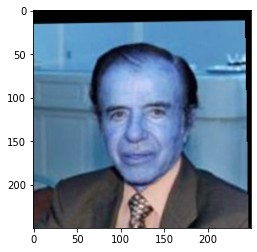

In [3]:
plt.imshow(img)
plt.show()

In [4]:
#Convertimos la imagen a grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(250, 250)

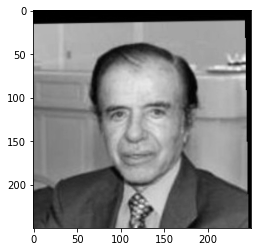

In [5]:
plt.imshow(gray, cmap="gray")
plt.show()

In [6]:
#Utilizamos haarcascades para identificar caras y ojos
#Buena explicacion: https://www.youtube.com/watch?v=J1jlm-I1cTs
face_cascade = cv2.CascadeClassifier("./opencv/haarcascades/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("./opencv/haarcascades/haarcascade_eye.xml")

In [7]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 63,  73, 118, 118]], dtype=int32)

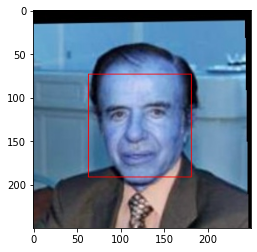

In [8]:
#Visualizamos la cara detectada
(x,y,w,h) = faces[0]
face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0))
plt.imshow(face_img)
plt.show()

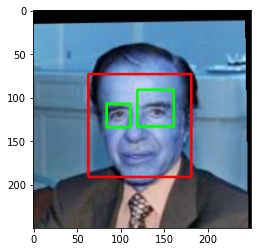

In [9]:
#Ahora vamos a detectar la cara y los ojos
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0),2)
    #Guardamos solamente la cara en gris (ya que es mas facil para la deteccion)
    roi_gray = gray[y:y+h, x:x+w]
    #Guardamos solamente la cara a color
    roi_color = face_img[y:y+h, x:x+w]
    #Ahora vamos a identificar los ojos
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew,ey+eh), (0,255,0),2)
plt.figure()
plt.imshow(face_img, cmap="gray")
plt.show()

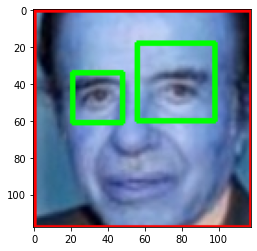

In [10]:
plt.imshow(roi_color, cmap="gray")
plt.show()

* Esto hace que el algoritmo entienda mejor la imagen (que se le haga mas facil reconocer los patrones

In [11]:
# thanks stackoverflow
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

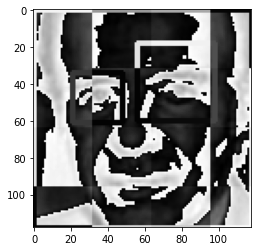

In [12]:
cropped_img = np.array(roi_color)
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

## Empezamos con nuestro proyecto

In [13]:
#Nos vamos a quedar solamente con las caras que tienen dos ojos
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [14]:
path_to_data = "./fotos_presidentes/"
path_to_cr_data = "./fotos_presidentes/cropped/"

In [15]:
#Cremos esta lista con el path de las carpetas de los presidentes, la vamos a utilizar mas adelante
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    name = os.path.basename(os.path.abspath(entry))
    if not name.startswith('.'):
        if entry.is_dir():
            img_dirs.append(entry.path)
img_dirs

['./fotos_presidentes/alberto_fernandez',
 './fotos_presidentes/carlos_menem',
 './fotos_presidentes/cristina_fernández',
 './fotos_presidentes/mauricio_macri',
 './fotos_presidentes/nestor_kirchner']

In [16]:
#Cremos una carpeta llamada cropped para almacenar las imagenes procesadas
#Si la carpeta existe la borra, y si no la crea
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [17]:
cropped_image_dirs = []
presidents_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    president_name = img_dir.split("/")[-1]
    print(president_name)
    
    presidents_file_names_dict[president_name] = []
    
    #Cada entry es cada foto que esta adentro de img_dir (cada img_dir es cada carpeta de los presidentes, adentro hay fotos)
    for entry in os.scandir(img_dir):
        name = os.path.basename(os.path.abspath(entry))
        if not name.startswith('.'):
            #entry.path devuelve el path de cada foto
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                cropped_folder = path_to_cr_data + president_name
                #Si esta carpeta no existe
                if not os.path.exists(cropped_folder):
                #Creamos la carpeta y hacemos un print para ver cuando la crea
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print (f"Generating cropped images in folder: {cropped_folder}")
                #Nombre de la foto
                cropped_file_name = president_name + str(count) + ".png"
                #Path de la foto
                cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
                #Guardamos la imagen en el path que le decimos
                cv2.imwrite(cropped_file_path, roi_color)
                #Diccionario como llave el nombre del presidente y como value el path (lo vamos a usar mas tarde)
                presidents_file_names_dict[president_name].append(cropped_file_path)
                count += 1
# CREO QUE EL ERROR ES QUE ESTOY MANDANDO MAL EL PATH A get_cropped_image_if_2_eyes

alberto_fernandez
Generating cropped images in folder: ./fotos_presidentes/cropped/alberto_fernandez
carlos_menem
Generating cropped images in folder: ./fotos_presidentes/cropped/carlos_menem
cristina_fernández
Generating cropped images in folder: ./fotos_presidentes/cropped/cristina_fernández
mauricio_macri
Generating cropped images in folder: ./fotos_presidentes/cropped/mauricio_macri
nestor_kirchner
Generating cropped images in folder: ./fotos_presidentes/cropped/nestor_kirchner


In [18]:
presidents_file_names_dict = {}
for img_dir in cropped_image_dirs:
    president_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        name = os.path.basename(os.path.abspath(entry))
        if not name.startswith('.'):
            file_list.append(entry.path)
    presidents_file_names_dict[president_name] = file_list
presidents_file_names_dict

{'alberto_fernandez': ['./fotos_presidentes/cropped/alberto_fernandez/alberto_fernandez1.png',
  './fotos_presidentes/cropped/alberto_fernandez/alberto_fernandez10.png',
  './fotos_presidentes/cropped/alberto_fernandez/alberto_fernandez2.png',
  './fotos_presidentes/cropped/alberto_fernandez/alberto_fernandez3.png',
  './fotos_presidentes/cropped/alberto_fernandez/alberto_fernandez4.png',
  './fotos_presidentes/cropped/alberto_fernandez/alberto_fernandez5.png',
  './fotos_presidentes/cropped/alberto_fernandez/alberto_fernandez6.png',
  './fotos_presidentes/cropped/alberto_fernandez/alberto_fernandez7.png',
  './fotos_presidentes/cropped/alberto_fernandez/alberto_fernandez8.png',
  './fotos_presidentes/cropped/alberto_fernandez/alberto_fernandez9.png'],
 'carlos_menem': ['./fotos_presidentes/cropped/carlos_menem/carlos_menem1.png',
  './fotos_presidentes/cropped/carlos_menem/carlos_menem10.png',
  './fotos_presidentes/cropped/carlos_menem/carlos_menem11.png',
  './fotos_presidentes/crop

In [19]:
#Cremos un diccionario con los nombres y un index
class_dict = {}
count = 0
for president_name in presidents_file_names_dict.keys():
    class_dict[president_name] = count
    count += 1
class_dict

{'alberto_fernandez': 0,
 'carlos_menem': 1,
 'cristina_fernández': 2,
 'mauricio_macri': 3,
 'nestor_kirchner': 4}

Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [20]:
X, y = [], []
#celebrity_name = nombre, training_files=path
#Para esto necesitabamos el diccionario
for president_name, training_files in presidents_file_names_dict.items():
    #training_image seria cada imagen, ya que si recorres un path devulve lo que tiene adentro, en este caso imagenes
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        #La convertimos en blanco y negro usando la def que hicimos mas arriba
        img_har = w2d(img, 'db1',5)
        scalled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[president_name])

In [21]:
len(X[0])

4096

In [22]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(83, 4096)

### Hacemos nuestro modelo

In [27]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#StandardScaler pone entre -1 y 1
#SVC el modelo suportvectoclassifier
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6666666666666666

Let's use GridSearch to try out different models with different paramets. Goal is to come up with best model with best fine tuned parameters

In [29]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [30]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [31]:
import pandas as pd
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_estimator_
    })
    best_estimators[algo] = clf.best_estimator_
df = pd.DataFrame(scores, columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.805128,"(StandardScaler(), SVC(C=1, gamma='auto', kern..."
1,random_forest,0.598718,"(StandardScaler(), (DecisionTreeClassifier(max..."
2,logistic_regression,0.789744,"(StandardScaler(), LogisticRegression(C=1, sol..."
